In [1]:
import json
import bz2
import regex
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()
from scipy import sparse
import codecs
import random

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\venv\nlp\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
# Перегоняем отзывы в dataframe
df = pd.DataFrame(responses)
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


Считаем отзывы по банкам и городам

In [6]:
sorted(df.bank_name.unique())

['2Т Банк',
 'АБ Финанс',
 'АББ',
 'АМБ Банк',
 'АМТ Банк',
 'АФ Банк',
 'Абсолют Банк',
 'Авангард',
 'Аверс',
 'Автоградбанк',
 'Автоторгбанк',
 'Агропромкредит',
 'Агророс',
 'Агросоюз',
 'Агрохимбанк',
 'Адамон Банк',
 'Адмиралтейский',
 'Азиатско-Тихоокеанский Банк',
 'Ай-Си-Ай-Си-Ай Банк (ICICI)',
 'АйМаниБанк',
 'Айви Банк',
 'Ак Барс',
 'Академический Русский Банк',
 'Акибанк',
 'Аксонбанк',
 'АктивКапитал Банк',
 'Акцент',
 'Акцепт',
 'Алданзолотобанк',
 'Александровский',
 'Алеф-Банк',
 'Алмазэргиэнбанк',
 'Алтынбанк',
 'Альта-Банк',
 'Альфа-Банк',
 'Анелик РУ',
 'Анкор Банк',
 'Анталбанк',
 'Арксбанк',
 'Аспект',
 'ББР Банк',
 'БИНБАНК кредитные карты',
 'БКС — Инвестиционный Банк',
 'БМВ Банк',
 'БНП Париба Банк',
 'БСТ-Банк',
 'БФГ-Кредит',
 'БайкалБанк',
 'БайкалИнвестБанк',
 'Байкалкредобанк',
 'Балтийский Банк',
 'Балтика',
 'Балтинвестбанк',
 'Банк «МБА-Москва»',
 'Банк «Санкт-Петербург»',
 'Банк АВБ',
 'Банк БКФ',
 'Банк БФА',
 'Банк БФТ',
 'Банк БЦК-Москва',
 'Банк В

Названия банков более-менее нормальные, но не учитываются переименовывания и слияния-поглощения (и еще вопрос как их учитывать)

In [7]:
df.city.unique()

array(['г. Москва', 'г. Новосибирск', 'г. Ставрополь', ...,
       'г. Москва-Владимир', 'г. СПб.',
       'г. Краснодарский край, ст.Павловская'], dtype=object)

С городами гораздо хуже, надо чистить. C кладром связываться не хочется, попробуем прогнать через наташу

In [8]:
from natasha import LocationExtractor

In [9]:
def extract_city(text):
    if isinstance(text, str):
        extractor = LocationExtractor()
        matches = extractor(text)
        if len(matches) > 0:
            return matches[0].fact.name
        else:
            return None
    else:
        return None

In [10]:
cities = pd.DataFrame(df.city.unique(), columns=['orig_name'])
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 1 columns):
orig_name    5823 non-null object
dtypes: object(1)
memory usage: 45.6+ KB


In [11]:
cities['clean_name'] = cities['orig_name'].progress_apply(extract_city)

In [12]:
cities

,orig_name,clean_name
0,г. Москва,москва
1,г. Новосибирск,новосибирск
2,г. Ставрополь,ставрополь
3,г. Челябинск,челябинск
4,г. Волгоград,волгоград
5,г. Пермь,пермь
6,г. Ростов-на-Дону,ростов
7,г. Воронеж,воронеж
8,г. Таганрог (Ростовская обл.),таганрог
9,г. Санкт-Петербург,петербург


In [13]:
cities.clean_name.count()

4773

In [14]:
cities.clean_name.value_counts()

москва                359
петербург             124
ростов                 51
московская область     51
московская обл         39
краснодарский край     27
химки                  24
мытищи                 23
екатеринбург           22
краснодар              22
уфа                    22
нижний новгород        22
казань                 21
красногорск            21
самар                  21
омск                   20
железногорск           20
волгоград              19
подольск               18
новосибирск            18
саратов                18
дзержинск              18
пушкино                18
люберцы                18
одинцово               17
тольятти               17
щелково                17
челябинск              17
клин                   16
башкортостан           16
                     ... 
оханск                  1
яросавль                1
будённовск              1
льгов                   1
мещовск                 1
город кстово            1
баево                   1
город искити

Потеряли тысячу уникальных записей, на выходе качество так себе - встречаются области, опечатки в городах и мифические города. По хорошему надо кладр прикручивать к форме на сайте, постфактум такое чистить с хорошим качеством можно только руками.

Но лучше, чем ничего.

In [15]:
df['clean_city'] = df['city'].replace(cities['orig_name'].tolist(), cities['clean_name'].tolist())

In [16]:
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,москва
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,новосибирск
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,москва
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...,ставрополь
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку,челябинск


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 11 columns):
author                153479 non-null object
bank_license          153498 non-null object
bank_name             153499 non-null object
city                  138325 non-null object
datetime              153499 non-null object
num_comments          153499 non-null int64
rating_grade          88658 non-null float64
rating_not_checked    153499 non-null bool
text                  153499 non-null object
title                 153499 non-null object
clean_city            135080 non-null object
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 11.9+ MB


In [18]:
df_clean_city = df.dropna(subset=['clean_city'])
df_clean_city.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135080 entries, 0 to 138946
Data columns (total 11 columns):
author                135079 non-null object
bank_license          135079 non-null object
bank_name             135080 non-null object
city                  135080 non-null object
datetime              135080 non-null object
num_comments          135080 non-null int64
rating_grade          73151 non-null float64
rating_not_checked    135080 non-null bool
text                  135080 non-null object
title                 135080 non-null object
clean_city            135080 non-null object
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 11.5+ MB


In [19]:
df_cnt_by_bank_city = df_clean_city.groupby(["bank_name", "clean_city"]).size().reset_index(name="Count").sort_values(by="Count", ascending=False)
df_cnt_by_bank_city

,bank_name,clean_city,Count
8495,Сбербанк России,москва,8435
665,Альфа-Банк,москва,4006
7319,Русский Стандарт,москва,2930
1818,ВТБ 24,москва,2783
8618,Сбербанк России,петербург,2627
4453,Московский Кредитный Банк,москва,2419
10308,Тинькофф Банк,москва,2403
11448,Хоум Кредит Банк,москва,2216
4851,Национальный Банк «Траст»,москва,1721
6107,Райффайзенбанк,москва,1475


Результаты ожидаемы - на первых местах из городов Москва/Санк-Петербург, а из банков - Сбербанк, Альфабанк, ВТБ и т.д.

In [20]:
del df_clean_city
del df_cnt_by_bank_city
del cities

import gc
gc.collect()

30294

Длинна текста в символах

In [21]:
df['text_len'] = df['text'].progress_apply(len)
df.sort_values(by="text_len", ascending=False)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_len
49155,Ден22ден,лицензия № 1481,Сбербанк России,г. Сафоново,2014-04-27 18:37:00,5,1.0,False,"Доброго времени суток. Я, Ливанцов Денис Анато...",Хамство и унижение посетителей,сафоново,32082
118257,cybernatic-cat,лицензия № 3292,Райффайзенбанк,г. Москва,2011-10-18 21:57:00,26,2.0,False,Весь пост (крайне объёмный) опубликован мной в...,Личный (и печальный) опыт попытки оспорить мош...,москва,29679
26023,ileon,лицензия № 2748,Банк Москвы,г. Москва,2014-11-22 20:04:00,12,1.0,False,Как и обещал в своем предыдущем отзыве от 29 о...,,москва,27364
38104,Knever,лицензия № 1481,Сбербанк России,г. Москва,2014-08-08 15:04:00,5,1.0,False,Введение оно же вывод. Данный отзыв содержит к...,,москва,27220
29058,ileon,лицензия № 2748,Банк Москвы,г. Москва,2014-10-29 07:49:00,30,NaN,False,"Представьте себе такую ситуацию: Вы, ежедневн...",Chargeback или семь кругов ада,москва,24992
86611,iSavaDev,лицензия № 1326,Альфа-Банк,г. Москва,2013-04-06 21:49:00,14,1.0,False,История за 10 лет... Напишу кратко (это действ...,"Больше нет причин, которые бы меня держали в э...",москва,24604
130012,irinka312,лицензия № 2820 (отозвана),АМТ Банк,г. Санкт-Петербург,2010-10-27 04:17:00,8,NaN,False,Добрый вечер всем. Являюсь клиентом Филиала ОО...,Удар ниже пояса,петербург,22540
121564,Dartema,лицензия № 2827,БИНБАНК кредитные карты,г. Москва,2011-07-15 12:05:00,11,NaN,False,"Данное письмо разместил по просьбе автора, и о...","Надеюсь, что ""Москомприватбанк"" не такой же, к...",москва,22484
77812,Origami,лицензия № 1978,Московский Кредитный Банк,г. Москва,2013-07-31 05:41:00,4,4.0,False,"Это мой первый отзыв на портале, посему прошу ...",,москва,21704
93607,Максим Оренбург,лицензия № 3354,Ренессанс Кредит,г. Оренбург,2013-01-10 11:23:00,19,NaN,False,В 2007 году я попытался взять кредит в банке К...,Кредит и возврат бракованного товара,оренбург,21118


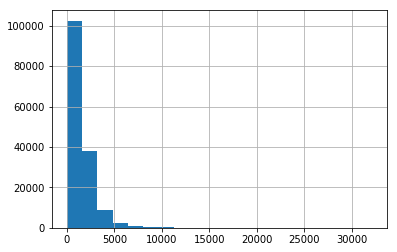

In [22]:
df['text_len'].hist(bins=20)

In [23]:
df['text_len'].describe()

count    153499.000000
mean       1554.212790
std        1319.098042
min          23.000000
25%         732.000000
50%        1193.000000
75%        1929.000000
max       32082.000000
Name: text_len, dtype: float64

Да, через твиттер отзывы оставлять было бы не очень удобно

Честно позаимствуем код для подготовки текста для анализа

In [24]:
import re
regex = re.compile("[а-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [25]:
df['text_words'] = df['text'].str.lower().progress_apply(words_only)
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_len,text_words
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,москва,1523,добрый день я не являюсь клиентом банка и пору...
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,новосибирск,1026,доброго дня являюсь держателем зарплатной карт...
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,москва,588,здравствуйте дублирую свое заявление от в до м...
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...,ставрополь,740,добрый день я открыл расчетный счет в сбербанк...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку,челябинск,1896,г взяла кредит в вашем банке заявленная мною с...


In [26]:
df['words_count'] = df['text_words'].progress_apply(lambda x: len(x.split()))
df.sort_values(by="words_count", ascending=False)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_len,text_words,words_count
49155,Ден22ден,лицензия № 1481,Сбербанк России,г. Сафоново,2014-04-27 18:37:00,5,1.0,False,"Доброго времени суток. Я, Ливанцов Денис Анато...",Хамство и унижение посетителей,сафоново,32082,доброго времени суток я ливанцов денис анатоль...,5001
118257,cybernatic-cat,лицензия № 3292,Райффайзенбанк,г. Москва,2011-10-18 21:57:00,26,2.0,False,Весь пост (крайне объёмный) опубликован мной в...,Личный (и печальный) опыт попытки оспорить мош...,москва,29679,весь пост крайне объ мный опубликован мной в ж...,4099
38104,Knever,лицензия № 1481,Сбербанк России,г. Москва,2014-08-08 15:04:00,5,1.0,False,Введение оно же вывод. Данный отзыв содержит к...,,москва,27220,введение оно же вывод данный отзыв содержит кр...,4021
86611,iSavaDev,лицензия № 1326,Альфа-Банк,г. Москва,2013-04-06 21:49:00,14,1.0,False,История за 10 лет... Напишу кратко (это действ...,"Больше нет причин, которые бы меня держали в э...",москва,24604,история за лет напишу кратко это действительно...,3939
26023,ileon,лицензия № 2748,Банк Москвы,г. Москва,2014-11-22 20:04:00,12,1.0,False,Как и обещал в своем предыдущем отзыве от 29 о...,,москва,27364,как и обещал в своем предыдущем отзыве от октя...,3557
29058,ileon,лицензия № 2748,Банк Москвы,г. Москва,2014-10-29 07:49:00,30,NaN,False,"Представьте себе такую ситуацию: Вы, ежедневн...",Chargeback или семь кругов ада,москва,24992,представьте себе такую ситуацию вы ежедневно п...,3509
121564,Dartema,лицензия № 2827,БИНБАНК кредитные карты,г. Москва,2011-07-15 12:05:00,11,NaN,False,"Данное письмо разместил по просьбе автора, и о...","Надеюсь, что ""Москомприватбанк"" не такой же, к...",москва,22484,данное письмо разместил по просьбе автора и он...,3373
77812,Origami,лицензия № 1978,Московский Кредитный Банк,г. Москва,2013-07-31 05:41:00,4,4.0,False,"Это мой первый отзыв на портале, посему прошу ...",,москва,21704,это мой первый отзыв на портале посему прошу н...,3169
130012,irinka312,лицензия № 2820 (отозвана),АМТ Банк,г. Санкт-Петербург,2010-10-27 04:17:00,8,NaN,False,Добрый вечер всем. Являюсь клиентом Филиала ОО...,Удар ниже пояса,петербург,22540,добрый вечер всем являюсь клиентом филиала ооо...,3167
131322,GeniusLoxly,лицензия № 1481,Сбербанк России,г. Елизово,2010-08-29 07:05:00,13,3.0,False,Подсадили нас на Сбербанк в организации. Орган...,"Все равно его не брошу, потому что…",елизово,20720,подсадили нас на сбербанк в организации органи...,3152


Иногда встречается транслит - надо его как-то тоже обрабатывать

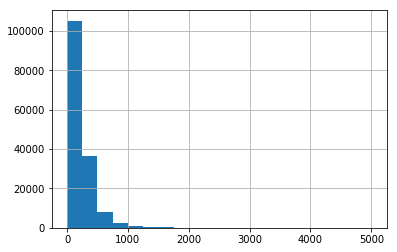

In [27]:
df['words_count'].hist(bins=20)

In [28]:
df['words_count'].describe()

count    153499.000000
mean        230.811751
std         196.607612
min           0.000000
25%         108.000000
50%         177.000000
75%         287.000000
max        5001.000000
Name: words_count, dtype: float64

Исследуем слова дальше

In [29]:
from collections import Counter
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_words'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))
for i in cnt.most_common(10):
    print(i)


('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


### Кривая Ципфа

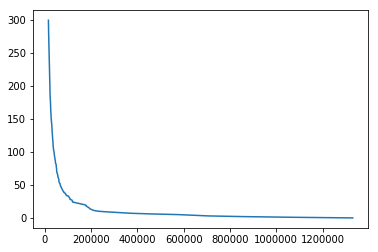

In [30]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Кривая Хипса

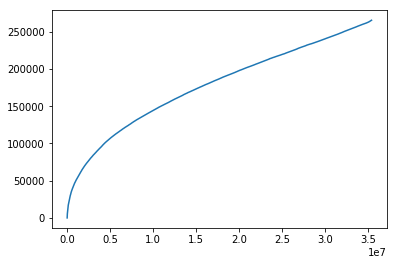

In [31]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

Словарь стоп-слов не помешает

In [32]:
from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vvoda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
df['text_words_stop'] = df['text_words'].progress_apply(remove_stopwords)

In [34]:
cnt_stop = Counter()
n_types_stop = []
n_tokens_stop = []
tokens_stop = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_stop = row['text_words_stop'].split()
    cnt_stop.update(tokens_stop)
    n_types_stop.append(len(cnt_stop))
    n_tokens_stop.append(sum(list(cnt_stop.values())))
for i in cnt_stop.most_common(10):
    print(i)


('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


### Кривая Ципфа

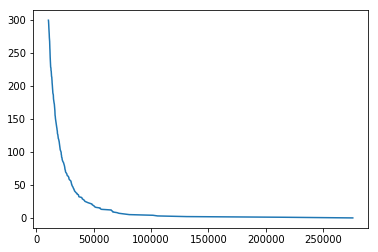

In [35]:
freqs = list(cnt_stop.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Кривая Хипса

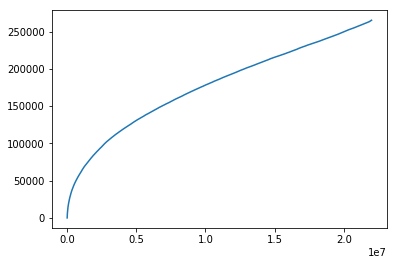

In [36]:
fig, ax = plt.subplots()
ax.plot(n_tokens_stop, n_types_stop)
plt.show()

Уже интереснее, посмотрим что там с леммами

In [37]:
#from pymystem3 import Mystem
#m = Mystem()
#mystem ну очень тормозит - 48 часов, попробуем через коммандную строку - 7 часов

#pymorphy2 шустрее всех остальных - 1 час
from pymorphy2 import MorphAnalyzer
pm2 = MorphAnalyzer()

#RNNMorph - 10 часов
#from rnnmorph.predictor import RNNMorphPredictor
from nltk.tokenize import toktok
toktok = toktok.ToktokTokenizer()
#pred = RNNMorphPredictor(language="ru")


def lemmatize(text, morph=pm2):
    try:
        #return "".join(m.lemmatize(text)).strip()
        return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
        #tokens = tok.tokenize(text, return_str=True)
        #forms = predictor.predict(tokens.split())
        #return ' '.join([form.normal_form for form in forms])
    except:
        return " "

def mystem_analysis(text):
    try:
        in_file = uuid.uuid4().hex
        out_file = uuid.uuid4().hex
        with codecs.open(in_file, 'w', encoding='utf8') as f:
            f.write(text)

        !mystem -i --format json {in_file} {out_file}

        with codecs.open(out_file, 'r', encoding='utf8') as f:
            out = f.read()
            
        os.remove(in_file)
        os.remove(out_file)
        return out
    except:
        return " "

def pymorph_analysis(text):
    try:
        return [pm2.parse(word) for word in toktok.tokenize(text)]
    except:
        return []

In [38]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return " "

In [39]:
def get_lemmas(arr):
    return ' '.join([lemma[0].normal_form for lemma in arr if not lemma[0].normal_form in mystoplemmas])

In [40]:
df['text_analysis'] = df['text_words_stop'].progress_apply(pymorph_analysis)

In [41]:
df['lemma'] = df['text_analysis'].progress_apply(get_lemmas)

In [42]:
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_len,text_words,words_count,text_words_stop,text_analysis,lemma
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,москва,1523,добрый день я не являюсь клиентом банка и пору...,213,добрый день являюсь клиентом банка поручителем...,"[[(добрый, ADJF,Qual masc,sing,nomn, добрый, 0...",добрый день являться клиент банка поручитель к...
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,новосибирск,1026,доброго дня являюсь держателем зарплатной карт...,135,доброго дня являюсь держателем зарплатной карт...,"[[(доброго, ADJF,Qual neut,sing,gent, добрый, ...",добрый день являться держатель зарплатный карт...
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,москва,588,здравствуйте дублирую свое заявление от в до м...,83,здравствуйте дублирую свое заявление можайский...,"[[(здравствуйте, VERB,impf,intr plur,impr,excl...",здравствовать дублировать заявление можайский ...
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...,ставрополь,740,добрый день я открыл расчетный счет в сбербанк...,121,добрый день открыл расчетный счет сбербанке юр...,"[[(добрый, ADJF,Qual masc,sing,nomn, добрый, 0...",добрый день открыть расчётный счёт сбербанк юр...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку,челябинск,1896,г взяла кредит в вашем банке заявленная мною с...,291,г взяла кредит вашем банке заявленная мною сум...,"[[(г, NOUN,inan,masc,Fixd,Abbr sing,nomn, год,...",год взять кредит ваш банка заявить я сумма руб...


In [43]:
cnt_lemmas = Counter()
n_types_lemmas = []
n_tokens_lemmas = []
tokens_lemmas = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_lemmas = row['lemma'].split()
    cnt_lemmas.update(tokens_lemmas)
    n_types_lemmas.append(len(cnt_lemmas))
    n_tokens_lemmas.append(sum(list(cnt_lemmas.values())))
for i in cnt_lemmas.most_common(10):
    print(i)


('банка', 399725)
('карта', 334999)
('банк', 268864)
('деньга', 179819)
('день', 170152)
('год', 169247)
('кредит', 156177)
('мой', 156140)
('отделение', 144050)
('клиент', 136893)


Лемматизация произошла не совсем корректно (банка и банк), но ждать 7+ часов не хочется

### Кривая Ципфа

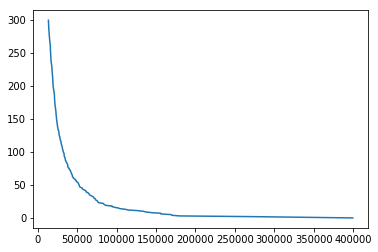

In [44]:
freqs = list(cnt_lemmas.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Кривая Хипса

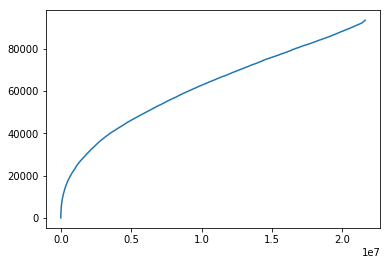

In [45]:
fig, ax = plt.subplots()
ax.plot(n_tokens_lemmas, n_types_lemmas)
plt.show()

In [46]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun = []
tokens_noun = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_noun = [lemma[0].normal_form for lemma in row['text_analysis'] if 'NOUN' in lemma[0].tag]
    cnt_noun.update(tokens_noun)
    n_types_noun.append(len(cnt_noun))
    n_tokens_noun.append(sum(list(cnt_noun.values())))
for i in cnt_noun.most_common(10):
    print(i)


('банка', 399725)
('карта', 334999)
('банк', 268864)
('деньга', 179819)
('день', 170152)
('год', 169247)
('кредит', 156177)
('отделение', 144050)
('клиент', 136893)
('сотрудник', 134168)


9 из 10 частоупотребляеммых лемм - существительные

### Кривая Ципфа

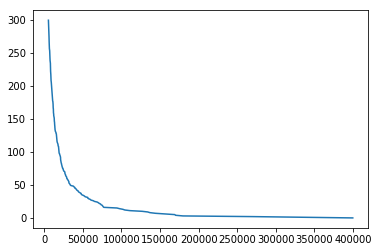

In [47]:
freqs = list(cnt_noun.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Кривая Хипса

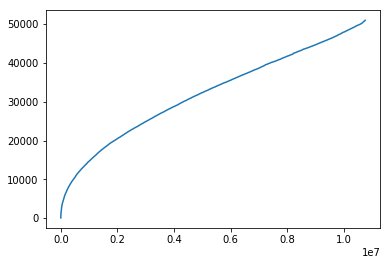

In [48]:
fig, ax = plt.subplots()
ax.plot(n_tokens_noun, n_types_noun)
plt.show()

In [49]:
print(f"слово \"сотрудник\" встречается {cnt['сотрудник']} раз")
print(f"слово \"клиент\" встречается {cnt['клиент']} раз")
if cnt['клиент'] > cnt['сотрудник']:
      print("слово \"клиент\" встречается чаще, чем слово \"сотрудник\"")
else:
      print("слово \"сотрудник\" встречается чаще, чем слово \"клиент\"")

слово "сотрудник" встречается 31189 раз
слово "клиент" встречается 20160 раз
слово "сотрудник" встречается чаще, чем слово "клиент"


In [50]:
#сколько раз встречается слова "мошенничество" и "доверие"
print(f"слово \"мошенничество\" встречается {cnt['мошенничество']} раз")
print(f"слово \"доверие\" встречается {cnt['доверие']} раз")
if cnt['доверие'] > cnt['мошенничество']:
      print("слово \"доверие\" встречается чаще, чем слово \"мошенничество\"")
else:
      print("слово \"мошенничество\" встречается чаще, чем слово \"доверие\"")

слово "мошенничество" встречается 1106 раз
слово "доверие" встречается 1156 раз
слово "доверие" встречается чаще, чем слово "мошенничество"


Попробуем подсчитать тоже самое по леммам

In [51]:
print(f"лемма \"сотрудник\" встречается {cnt_lemmas['сотрудник']} раз")
print(f"лемма \"клиент\" встречается {cnt_lemmas['клиент']} раз")
if cnt_lemmas['клиент'] > cnt_lemmas['сотрудник']:
      print("лемма \"клиент\" встречается чаще, чем лемма \"сотрудник\"")
else:
      print("лемма \"сотрудник\" встречается чаще, чем лемма \"клиент\"")

лемма "сотрудник" встречается 134168 раз
лемма "клиент" встречается 136893 раз
лемма "клиент" встречается чаще, чем лемма "сотрудник"


In [52]:
print(f"лемма \"мошенничество\" встречается {cnt_lemmas['мошенничество']} раз")
print(f"лемма \"доверие\" встречается {cnt_lemmas['доверие']} раз")
if cnt_lemmas['доверие'] > cnt_lemmas['мошенничество']:
      print("лемма \"доверие\" встречается чаще, чем лемма \"мошенничество\"")
else:
      print("лемма \"мошенничество\" встречается чаще, чем лемма \"доверие\"")

лемма "мошенничество" встречается 3244 раз
лемма "доверие" встречается 2108 раз
лемма "мошенничество" встречается чаще, чем лемма "доверие"


Любопытно, но с леммами ситуация обратная

#### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру 𝑡𝑓−𝑖𝑑𝑓, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [53]:
df['rating_grade'].fillna(0, inplace=True)
df['rating_grade'].unique()

array([0., 2., 1., 5., 3., 4.])

In [54]:
tokens_by_rating = []
for rating in range(6):
    print(rating)
    tokens = []
    sample = df[df['rating_grade']==rating]['lemma']

    for i in range(len(sample)):
        tokens += sample.iloc[i].split()
    tokens_by_rating.append(tokens)

0
1
2
3
4
5


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [56]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking1_uni = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_uni.append(phrase)

### Униграммы отрицательных отзывов

In [57]:
rankings = pd.DataFrame({'negtive_uni': tfidf_ranking1_uni})
rankings.head(10)

,negtive_uni
0,банка
1,карта
2,банк
3,деньга
4,день
5,год
6,отделение
7,мой
8,кредит
9,сотрудник


In [58]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking1_bi = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_bi.append(phrase)

### Биграммы отрицательных отзывов

In [59]:
rankings = pd.DataFrame({'negative_bi': tfidf_ranking1_bi})
rankings.head(10)

,negative_bi
0,сотрудник банка
1,кредитный карта
2,отделение банка
3,денежный средство
4,написать заявление
5,горячий линия
6,рабочий день
7,колл центр
8,следующий день
9,клиент банка


In [60]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking5_uni = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_uni.append(phrase)

### Униграммы положительных отзывов

In [61]:
rankings = pd.DataFrame({'positive_uni': tfidf_ranking5_uni})
rankings.head(10)

,positive_uni
0,банка
1,банк
2,карта
3,очень
4,год
5,кредит
6,день
7,клиент
8,отделение
9,сотрудник


In [62]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking5_bi = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_bi.append(phrase)

### Биграммы положительных отзывов

In [63]:
rankings = pd.DataFrame({'positive_bi': tfidf_ranking5_bi})
rankings.head(10)

,positive_bi
0,кредитный карта
1,сотрудник банка
2,интернет банк
3,другой банка
4,клиент банка
5,следующий день
6,являться клиент
7,отделение банка
8,дебетовый карта
9,добрый день


### Сводная таблица

In [64]:
rankings = pd.DataFrame({'negtive_uni': tfidf_ranking1_uni, 'negative_bi': tfidf_ranking1_bi, 'positive_uni': tfidf_ranking5_uni, 'positive_bi': tfidf_ranking5_bi})
rankings.head(10)

,negtive_uni,negative_bi,positive_uni,positive_bi
0,банка,сотрудник банка,банка,кредитный карта
1,карта,кредитный карта,банк,сотрудник банка
2,банк,отделение банка,карта,интернет банк
3,деньга,денежный средство,очень,другой банка
4,день,написать заявление,год,клиент банка
5,год,горячий линия,кредит,следующий день
6,отделение,рабочий день,день,являться клиент
7,мой,колл центр,клиент,отделение банка
8,кредит,следующий день,отделение,дебетовый карта
9,сотрудник,клиент банка,сотрудник,добрый день


c:\venv\nlp\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


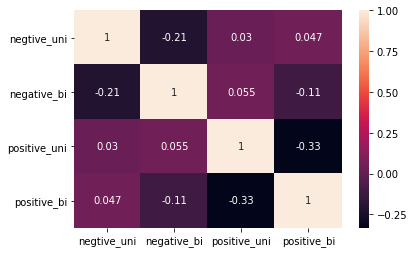

In [65]:
from scipy.stats import spearmanr
import seaborn as sns
%matplotlib inline
corr = spearmanr(rankings).correlation
sns.heatmap(corr, annot=True, xticklabels = list(rankings), yticklabels = list(rankings))

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [66]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [67]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [96]:
random.seed(42)

Как выяснилось, разбиение на темы зависит от ГПСЧ

In [97]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, alpha='auto', eta='auto', iterations = 20, passes = 5)

Wall time: 12min 49s


In [98]:
lda.show_topics(20)

[(0,
  '0.181*"кредит" + 0.037*"банка" + 0.033*"кредитный" + 0.032*"банк" + 0.032*"год" + 0.021*"брать" + 0.021*"взять" + 0.016*"погасить" + 0.015*"месяц" + 0.014*"платить"'),
 (1,
  '0.040*"день" + 0.031*"сказать" + 0.028*"позвонить" + 0.023*"звонить" + 0.016*"банк" + 0.016*"неделя" + 0.013*"банка" + 0.013*"телефон" + 0.012*"ждать" + 0.011*"отделение"'),
 (2,
  '0.109*"деньга" + 0.102*"банкомат" + 0.020*"снять" + 0.016*"рубль" + 0.015*"сумма" + 0.015*"счёт" + 0.015*"день" + 0.013*"купюра" + 0.013*"вернуть" + 0.012*"чек"'),
 (3,
  '0.030*"банк" + 0.024*"рф" + 0.021*"суд" + 0.020*"право" + 0.016*"закон" + 0.011*"русский" + 0.011*"требование" + 0.011*"стандарт" + 0.009*"мой" + 0.009*"лицо"'),
 (4,
  '0.079*"счёт" + 0.069*"средство" + 0.057*"перевод" + 0.039*"операция" + 0.035*"деньга" + 0.028*"денежный" + 0.027*"комиссия" + 0.025*"банк" + 0.019*"сумма" + 0.018*"банка"'),
 (5,
  '0.044*"телефон" + 0.039*"номер" + 0.038*"звонок" + 0.033*"банка" + 0.028*"звонить" + 0.020*"ваш" + 0.016*"мой"

0. Кредитный договор
1. Телефонная поддержка
2. Банкоматы
3. Тяжбы с Русским Стандартом
4. Денежные переводы и комиссии
5. Телефонная поддержка Альфа-банка
6. Работа отделений
7. Заявления на получение карточек
8. Валютные вклады и депозиты
9. Работа банка с притензиями
10. Открытие счета в ВТБ
11. Ипотека
12. Интернет-банкинг Ситибанка
13. Вклады?
14. Страхование
15. (странный набор)
16. 
17. Обслуживание клиентов
18. Поддержка Сбербанка
19. Просроченные кредиты

In [99]:
%%time
lda15 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15, alpha='auto', eta='auto', iterations = 20, passes = 5)

Wall time: 11min 56s


In [100]:
lda15.show_topics(15)

[(0,
  '0.061*"кредит" + 0.041*"платёж" + 0.032*"сумма" + 0.024*"рубль" + 0.022*"год" + 0.021*"банка" + 0.021*"задолженность" + 0.019*"кредитный" + 0.018*"погашение" + 0.017*"месяц"'),
 (1,
  '0.043*"банка" + 0.023*"очень" + 0.022*"банк" + 0.021*"клиент" + 0.011*"работа" + 0.011*"обслуживание" + 0.009*"время" + 0.009*"вопрос" + 0.009*"сотрудник" + 0.009*"год"'),
 (2,
  '0.076*"кредит" + 0.038*"документ" + 0.018*"кредитный" + 0.017*"договор" + 0.015*"банка" + 0.013*"заявка" + 0.012*"справка" + 0.011*"сумма" + 0.011*"менеджер" + 0.010*"анкета"'),
 (3,
  '0.031*"банка" + 0.029*"телефон" + 0.025*"звонок" + 0.024*"номер" + 0.023*"звонить" + 0.019*"ваш" + 0.016*"мой" + 0.015*"сотрудник" + 0.014*"кредит" + 0.014*"человек"'),
 (4,
  '0.124*"вклад" + 0.040*"деньга" + 0.029*"открыть" + 0.025*"депозит" + 0.024*"процент" + 0.021*"договор" + 0.021*"банка" + 0.017*"сумма" + 0.014*"касса" + 0.014*"открывать"'),
 (5,
  '0.032*"очередь" + 0.027*"отделение" + 0.020*"работать" + 0.019*"минута" + 0.016*"к

0. Кредиты
1. Обслуживание клиентов
2. Заявки на кредит
3. Телефонная поддержка
4. Вклады/депозиты
5. Работа отделений
6. (что-то про Сбербанк)
7. Работа с притензиями
8. 
9. Судебные тяжбы
10. Банкоматы
11. Служба поддержки
12. Карты Ситибанка
13. Денежные переводы
14. Телефонная поддержка

In [101]:
%%time
lda10 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto', iterations = 20, passes = 5)

Wall time: 10min 54s


In [102]:
lda10.show_topics(10)

[(0,
  '0.016*"банк" + 0.011*"деньга" + 0.010*"такой" + 0.010*"сказать" + 0.009*"говорить" + 0.009*"просто" + 0.009*"один" + 0.007*"знать" + 0.007*"девушка" + 0.007*"банка"'),
 (1,
  '0.053*"деньга" + 0.033*"банкомат" + 0.025*"счёт" + 0.023*"день" + 0.021*"заявление" + 0.017*"сбербанк" + 0.016*"мой" + 0.013*"отделение" + 0.012*"сумма" + 0.012*"претензия"'),
 (2,
  '0.031*"телефон" + 0.031*"банка" + 0.025*"звонить" + 0.023*"звонок" + 0.021*"номер" + 0.018*"сотрудник" + 0.017*"мой" + 0.017*"ваш" + 0.012*"дать" + 0.010*"вопрос"'),
 (3,
  '0.025*"банка" + 0.022*"банк" + 0.015*"интернет" + 0.013*"клиент" + 0.012*"проблема" + 0.011*"система" + 0.009*"услуга" + 0.009*"платёж" + 0.009*"счёт" + 0.009*"перевод"'),
 (4,
  '0.056*"вклад" + 0.032*"счёт" + 0.030*"банка" + 0.021*"комиссия" + 0.021*"процент" + 0.019*"сумма" + 0.018*"банк" + 0.017*"рубль" + 0.016*"деньга" + 0.014*"открыть"'),
 (5,
  '0.028*"отделение" + 0.019*"банка" + 0.019*"очередь" + 0.017*"офис" + 0.015*"клиент" + 0.015*"работать" 

0. 
1. Проблемы с банкоматами Сбербанка
2. Телефонная поддержка
3. Проблемы интернет-банкинга
4. Вклады/депозиты
5. Работа отделений
6. Проблемы с договорами
7. Заявки на кредит
8. Кредитные задолженности
9. Карты Ситибанка

Процент объяснимых тем примерно везде одинаковый

Разбиение на темы сильно зависит от ГПСЧ - разные сиды дают сильно разные темы.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [115]:
df_class = df.loc[df['rating_grade'].isin([1, 5])][['bank_name', 'clean_city', 'num_comments', 'lemma', 'words_count', 'rating_grade']].reset_index(drop=True)

In [116]:
df_class['rating'] = df_class['rating_grade'].apply(lambda x: 1 if x == 5 else 0)

In [ ]:
df_class.to_pickle('df_class.zip')

In [3]:
df_class = pd.read_pickle('df_class.zip')

In [4]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62100 entries, 0 to 62099
Data columns (total 7 columns):
bank_name       62100 non-null object
clean_city      49299 non-null object
num_comments    62100 non-null int64
lemma           62100 non-null object
words_count     62100 non-null int64
rating_grade    62100 non-null float64
rating          62100 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 3.3+ MB


In [5]:
df_class.head()

,bank_name,clean_city,num_comments,lemma,words_count,rating_grade,rating
0,Сбербанк России,москва,2,открытый вклад счёт плюс это зарплатный карта ...,342,1.0,0
1,Сбербанк России,ростов,1,добрый время вчера поступить смс уведомление б...,311,1.0,0
2,АктивКапитал Банк,петербург,0,год около часы прийти указанный офис намерение...,184,1.0,0
3,Сбербанк России,москва,4,оплата коммунальный платёж пользоваться пласти...,57,1.0,0
4,Сбербанк России,чапаевск,16,апрель год пришлый отделение сбербанк год чапа...,265,1.0,0


In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [7]:
random.seed(42)

In [8]:
features = ['bank_name', 'clean_city', 'num_comments', 'lemma', 'words_count']
target = ['rating']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_class[features], df_class[target], test_size=0.2)

In [10]:
X_train.head()

,bank_name,clean_city,num_comments,lemma,words_count
14295,Восточный Экспресс Банк,братск,4,апрель получить необходимый документ перевод и...,214
19409,Ланта-Банк,петербург,0,хотеться выразить благодарность сотрудник лант...,79
24023,2Т Банк,петербург,0,пользоваться услуга банка несколько месяц вс у...,256
53170,Альфа-Банк,None,0,именно телефон долго распинаться законно итог ...,222
52195,Российский Капитал,None,5,отказывать доступ арендовать депозитный ячейка...,75


In [11]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [12]:
text1 = Pipeline([
    ('selector', TextSelector(key='lemma')),
    ('cnt_vect', CountVectorizer()),
    ('tfidf_tr', TfidfTransformer()),
    ('lsa', TruncatedSVD(n_components=100))
])
text1.fit_transform(X_train)

array([[ 2.36257254e-01, -9.64792883e-02, -2.67985754e-02, ...,
        -1.38798307e-02,  2.85559144e-02,  7.13708426e-04],
       [ 1.19179588e-01, -5.02056155e-02,  2.00252569e-02, ...,
        -7.43402649e-03, -1.35693047e-03, -1.91672709e-02],
       [ 2.67785661e-01,  1.49762678e-02,  1.39635402e-01, ...,
        -1.03808939e-02,  2.94121631e-02, -1.43230097e-02],
       ...,
       [ 2.11631345e-01,  3.31729549e-02, -1.99546276e-02, ...,
         2.49242482e-02, -2.74681349e-02,  7.54391048e-02],
       [ 2.35145670e-01,  7.10668213e-02, -2.93268709e-03, ...,
        -1.38050174e-02, -3.49009128e-04, -2.05860134e-02],
       [ 3.63565118e-01, -6.39504261e-02, -1.54390172e-01, ...,
        -6.27923028e-03, -1.30449694e-03, -5.09115968e-03]])

In [12]:
words_count = Pipeline([
    ('selector', ItemSelector(key='words_count')),
    ('std_scaler', StandardScaler())
])
words_count.fit_transform(X_train)

c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.20071877],
       [-0.851305  ],
       [ 0.00168583],
       ...,
       [-0.38384675],
       [-0.83202837],
       [ 1.44743301]])

In [13]:
num_comments = Pipeline([
    ('selector', ItemSelector(key='num_comments')),
    ('std_scaler', StandardScaler())
])
num_comments.fit_transform(X_train)

c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.03045382],
       [-0.56036755],
       [-0.56036755],
       ...,
       [-0.56036755],
       [-0.41266221],
       [-0.26495686]])

In [14]:
bank_name = Pipeline([
    ('selector', ItemSelector(key='bank_name')),
    ('dict_vec', OneHotEncoder(categories=[df_class['bank_name'].unique()]))
])
bank_name.fit_transform(X_train)

<49680x580 sparse matrix of type '<class 'numpy.float64'>'
	with 49680 stored elements in Compressed Sparse Row format>

In [15]:
city = Pipeline([
    ('selector', ItemSelector(key='clean_city')),
    ('dict_vec', OneHotEncoder(categories=[df_class['clean_city'].unique()]))
])
city.fit_transform(X_train)

<49680x969 sparse matrix of type '<class 'numpy.float64'>'
	with 49680 stored elements in Compressed Sparse Row format>

In [18]:
features1 = FeatureUnion([
    ('text1', text1),
    ('words_count', words_count),
    ('num_comments', num_comments),
    ('bank_name', bank_name),
    ('city', city)
])

In [19]:
clf1 = Pipeline([
    ('features', features1),
    ('clf', RandomForestClassifier())
])
clf1.fit(X_train, y_train)

c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text1', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='lemma')), ('cnt_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [20]:
preds = clf1.predict(X_test)
np.mean(preds == y_test['rating'])

c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.855475040257649

Precision:   0.88
Recall:   0.71
F1-measure:   0.75
Accuracy:   0.86
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      9472
           1       0.91      0.43      0.59      2948

   micro avg       0.86      0.86      0.86     12420
   macro avg       0.88      0.71      0.75     12420
weighted avg       0.86      0.86      0.84     12420



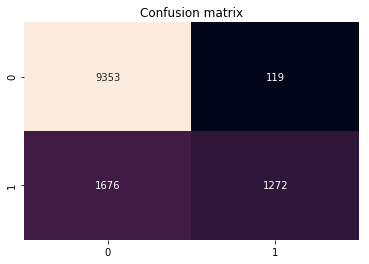

In [21]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf1.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Без подбра параметров уже хорошая точность по accuracy, но хуже по F1

In [22]:
clf1.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'clf', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__text1', 'features__words_count', 'features__num_comments', 'features__bank_name', 'features__city', 'features__text1__memory', 'features__text1__steps', 'features__text1__selector', 'features__text1__cnt_vect', 'features__text1__tfidf_tr', 'features__text1__lsa', 'features__text1__selector__key', 'features__text1__cnt_vect__analyzer', 'features__text1__cnt_vect__binary', 'features__text1__cnt_vect__decode_error', 'features__text1__cnt_vect__dtype', 'features__text1__cnt_vect__encoding', 'features__text1__cnt_vect__input', 'features__text1__cnt_vect__lowercase', 'features__text1__cnt_vect__max_df', 'features__text1__cnt_vect__max_features', 'features__text1__cnt_vect__min_df', 'features__text1__cnt_vect__ngram_range', 'features__text1__cnt_vect__preprocessor', 'features__text1__cnt_vect__stop_words', 'features__text1__cnt_vect__strip_accents', 'f

In [23]:
hyperparams = {
    'features__text1__cnt_vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
}

grid1 = GridSearchCV(clf1, hyperparams, cv=5, verbose=10, n_jobs=4, scoring='f1')
grid1.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed: 15.4min remaining:  7.7min
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed: 39.5min remaining:  9.9min
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 47.2min finished
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text1', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='lemma')), ('cnt_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'features__text1__cnt_vect__ngram_range': [(1, 1), (2, 2), (3, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=10)

In [24]:
print(grid1.best_params_)
print(grid1.best_score_)

{'features__text1__cnt_vect__ngram_range': (1, 1)}
0.5916851463021996


c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Precision:   0.88
Recall:   0.72
F1-measure:   0.76
Accuracy:   0.86
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      9472
           1       0.92      0.45      0.60      2948

   micro avg       0.86      0.86      0.86     12420
   macro avg       0.88      0.72      0.76     12420
weighted avg       0.87      0.86      0.84     12420



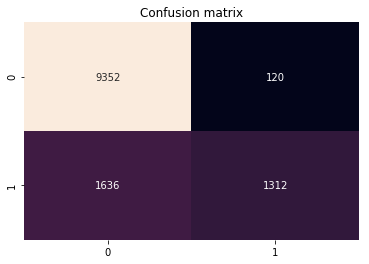

In [25]:
preds = grid1.best_estimator_.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf1.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Значительно улучшить результат не получилось.

Лучше всего работают униграммы.

Результат зависит от ГПСЧ.

Триграммы считаются ну очень долго.

In [27]:
text2 = Pipeline([
    ('selector', TextSelector(key='lemma')),
    ('cnt_vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('tfidf_tr', TfidfTransformer()),
    ('lsa', TruncatedSVD(n_components=100))
])
text1.fit_transform(X_train)

array([[ 0.23625725, -0.09647917, -0.0267986 , ...,  0.03114487,
        -0.01029539,  0.00553989],
       [ 0.11917959, -0.05020567,  0.02002534, ...,  0.01256701,
        -0.02976576, -0.00952686],
       [ 0.26778566,  0.01497633,  0.13963541, ..., -0.00326588,
         0.00844652,  0.0209487 ],
       ...,
       [ 0.21163135,  0.03317291, -0.0199546 , ...,  0.05219903,
        -0.04639692, -0.01433147],
       [ 0.23514567,  0.07106686, -0.00293267, ...,  0.01853452,
        -0.00621342, -0.00063945],
       [ 0.36356512, -0.0639505 , -0.15439019, ..., -0.0135146 ,
        -0.03636106, -0.01062212]])

In [28]:
features2 = FeatureUnion([
    ('text2', text2),
    ('words_count', words_count),
    ('num_comments', num_comments),
    ('bank_name', bank_name),
    ('city', city)
])

In [31]:
clf2 = Pipeline([
    ('features', features2),
    ('clf', RandomForestClassifier())
])
clf2.fit(X_train, y_train)

c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\venv\nlp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text2', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='lemma')), ('cnt_vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [32]:
preds = clf2.predict(X_test)
np.mean(preds == y_test['rating'])

c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8524154589371981

Precision:   0.88
Recall:   0.70
F1-measure:   0.74
Accuracy:   0.85
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      9472
           1       0.91      0.42      0.57      2948

   micro avg       0.85      0.85      0.85     12420
   macro avg       0.88      0.70      0.74     12420
weighted avg       0.86      0.85      0.83     12420



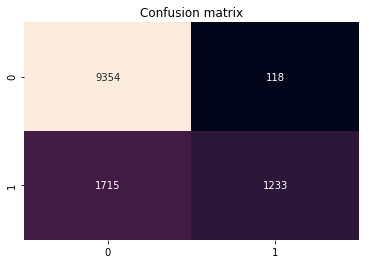

In [34]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf2.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Значительных различий между униграммами и символьным походом нет

In [22]:
text3 = Pipeline([
    ('selector', TextSelector(key='lemma')),
    ('cnt_vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('tfidf_tr', TfidfTransformer()),
    ('lda', LatentDirichletAllocation(n_components=20, n_jobs=4, verbose=10))
])

In [23]:
features3 = FeatureUnion([
    ('text3', text3),
    ('words_count', words_count),
    ('num_comments', num_comments),
    ('bank_name', bank_name),
    ('city', city)
])

In [24]:
clf3 = Pipeline([
    ('features', features3),
    ('clf', RandomForestClassifier(n_jobs=4, verbose=10))
])
clf3.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  6.0min remaining:  6.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.1min finished


iteration: 1 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.3min remaining:  4.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.4min finished


iteration: 2 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.5min finished


iteration: 3 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min finished


iteration: 4 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min finished


iteration: 5 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min finished


iteration: 6 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 7 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 8 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 9 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.2s remaining:   36.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.6s remaining:   34.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.4s finished
c:\venv\nlp\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\venv\nlp\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).tran

building tree 1 of 10building tree 2 of 10building tree 3 of 10building tree 4 of 10



building tree 5 of 10
building tree 6 of 10
building tree 7 of 10building tree 8 of 10

building tree 9 of 10

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s



building tree 10 of 10

[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.9s remaining:    0.8s


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.7s finished


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text3', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='lemma')), ('cnt_vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=..._jobs=4,
            oob_score=False, random_state=None, verbose=10,
            warm_start=False))])

In [25]:
preds = clf3.predict(X_test)
np.mean(preds == y_test['rating'])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   12.2s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.3s finished
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\venv\nlp\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


0.799597423510467

Precision:   0.76
Recall:   0.61
F1-measure:   0.63
Accuracy:   0.80
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      9472
           1       0.71      0.26      0.38      2948

   micro avg       0.80      0.80      0.80     12420
   macro avg       0.76      0.61      0.63     12420
weighted avg       0.79      0.80      0.76     12420



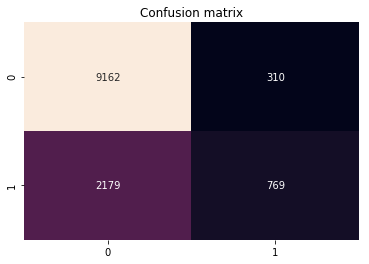

In [27]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))
labels = clf3.classes_
sns.heatmap(data=confusion_matrix(y_test['rating'], preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

LDA отработало хуже, чем SVD. Возможно, это связано с меньшим количеством фичей (20 против 100). Ну и LDA работает медленнее, чем SVD